# Data Cleaning and EDA

This notebook consists of bringing different datasets together.

### Import

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

### Read the data needed

Income and employment data was cleaned earlier in another data, all this data comes from Bureau of Labor Statistics and US Census Bureu websites.

In [2]:
income = pd.read_csv('../../datasets/income and population/median_income_per_state.csv')
employment = pd.read_csv('../../datasets/income and population/employment_by_county.csv')

In [3]:
fema_disaster = pd.read_csv('https://www.dropbox.com/s/csf8o84x2olw7n2/clean_fema_data?dl=1', index_col='Unnamed: 0')

### Data cleaning

In [270]:
fema_disaster.shape

(48259, 17)

In [362]:
fema_disaster['Title'].unique()

array(['TROPICAL STORM MICHAEL', 'SEVERE STORMS AND FLOODING',
       'EARTHQUAKE', ..., 'TYPHOON & HIGH TIDES', 'HURRICANE BETSY',
       'FLOOD'], dtype=object)

In [272]:
fema_disaster.isnull().sum()

Disaster Number                 0
IH Program Declared             0
IA Program Declared             0
PA Program Declared             0
HM Program Declared             0
State                           0
Declaration Date                0
Disaster Type                   0
Incident Type                   0
Title                           0
Incident Begin Date             0
Incident End Date             338
Place Code                      0
Declared County/Area            0
Declaration Request Number      0
Incident Duration Days        338
time                            0
dtype: int64

In [4]:
county_disaster = fema_disaster[(fema_disaster['Declared County/Area'].str.contains('(County)')) | (fema_disaster['Declared County/Area'].str.contains('(Parish)'))]

/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [5]:
county_disaster.loc[:,'Incident Begin Date'] = pd.to_datetime(county_disaster.loc[:,'Incident Begin Date'])
county_disaster.loc[:,'Incident End Date'] = pd.to_datetime(county_disaster.loc[:,'Incident End Date'])

/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
disasters_from_1980 = county_disaster[county_disaster['Incident Begin Date'] > '1980-01-01']
disasters_from_1980.reset_index(drop='index', inplace=True)

### Data cleaning and EDA

In [14]:
disasters_from_1980.groupby('Title')['Declared County/Area'].describe().sort_values(by='unique', ascending=False)

,count,unique,top,freq
Title,,,,
HURRICANE KATRINA EVACUATION,2559,1572,Washington (County),23
SEVERE STORMS AND FLOODING,3404,1188,Washington (County),42
SEVERE STORMS & FLOODING,1607,815,Franklin (County),18
SEVERE WINTER STORM,1851,735,Washington (County),19
"SEVERE STORMS, TORNADOES, AND FLOODING",1686,683,Jackson (County),17
...,...,...,...,...
HARRAH FIRE,1,1,Oklahoma (County),1
HARDY FIRE,1,1,Coconino (County),1
GW FIRE,1,1,Deschutes (County),1


#### Choosing the necessary columns from the data we have and try to form a cleaner dataframe.

In [15]:
df = disasters_from_1980[['Disaster Number', 'Disaster Type', 'Incident Type', 'Title', 'State ', 'Declared County/Area', 'Incident Duration Days', 'Incident Begin Date']]

In [16]:
df.loc[:,'Declared County/Area'] = df.loc[:,'Declared County/Area'].str.replace('(', '')
df.loc[:,'Declared County/Area'] = df.loc[:,'Declared County/Area'].str.replace(')', '')

In [17]:
df.rename(columns={'Declared County/Area':'county'}, inplace=True)

/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


**ha_df** might not seem the most explanatory variable name, what it does is use the disaster data and merge it with the employment information on counties.

In [18]:
ha_df = pd.merge(df, employment, how='left', left_on='county', right_on='county')

In [19]:
ha_df.isnull().sum()

Disaster Number              0
Disaster Type                0
Incident Type                0
Title                        0
State                        0
county                       0
Incident Duration Days    1564
Incident Begin Date          0
Unnamed: 0                 707
state                      707
employed                   707
dtype: int64

In [20]:
ha_df.drop(columns=['Unnamed: 0', 'state'], inplace=True)

In [21]:
ha_df.dropna(inplace=True)

In [22]:
ha_df.shape

(181312, 9)

In [24]:
ha_df['Incident Duration Days'] = ha_df['Incident Duration Days'].str.replace(' days 00:00:00.000000000','')

In [25]:
ha_df.to_csv('../../datasets/robbie_needs_this.csv', index=False)

After saving this dataframe, we will add new features such as average income per state.

In [26]:
income = pd.read_csv('../../datasets/income and population/median_income_per_state.csv')

In [27]:
income.drop(columns='Unnamed: 0', inplace=True)

In [28]:
income['avg_wage_per_hour'] = round((((income['median_income']/52)/7)/3),2)

In [29]:
income.rename(columns={'county':'state'},inplace=True)

In [30]:
employment['state'] = employment['state'].str.replace(' ','')

In [31]:
states = list(employment['state'].unique())

This is a part where I am trying to change the state names and also add the corresponding avg_wage for these states.

In [32]:
for i in range(len(states)):
    income_state = income.iloc[i]['state']
    income['state'] = income['state'].str.replace(income_state,states[i])

In [33]:
income['state'] = income['state'].str.replace('DisctrictofColumbia','Disctrict of Columbia')

In [34]:
clean = pd.merge(ha_df, income, how='left', left_on='State ', right_on='state')

In [35]:
clean.drop(columns=['state','median_income'],inplace=True)

In [36]:
clean.to_csv('../../datasets/important_data.csv')

Always save your work.

# REWORK

This part of the code was added after we have figured what to do in the model we formed. It is designed to be as compatible as possible to the ARIMA model.

In [38]:
clean.head()

,Disaster Number,Disaster Type,Incident Type,Title,State,county,Incident Duration Days,Incident Begin Date,employed,avg_wage_per_hour
0,4411.0,DR,Hurricane,TROPICAL STORM MICHAEL,VA,Amelia County,7,2018-10-09,6328.0,55.66
1,4411.0,DR,Hurricane,TROPICAL STORM MICHAEL,VA,Appomattox County,7,2018-10-09,7032.0,55.66
2,4411.0,DR,Hurricane,TROPICAL STORM MICHAEL,VA,Brunswick County,7,2018-10-09,51264.0,55.66
3,4411.0,DR,Hurricane,TROPICAL STORM MICHAEL,VA,Brunswick County,7,2018-10-09,5736.0,55.66
4,4411.0,DR,Hurricane,TROPICAL STORM MICHAEL,VA,Campbell County,7,2018-10-09,50068.0,55.66


In [39]:
hurricanes = clean[clean['Title'].str.contains('HURRICANE')].groupby('Disaster Number').agg({'employed':'sum'})

In [40]:
hurricanes.head()

,employed
Disaster Number,
627.0,1236581.0
689.0,4994880.0
724.0,272006.0
741.0,1064955.0
742.0,294460.0


In [41]:
hurricanes.reset_index(inplace=True)

In [42]:
cc = clean[['Disaster Number','Title','Disaster Type','State ', 'Incident Duration Days', 'Incident Begin Date']]

In [47]:
cc.head()

,Disaster Number,Title,Disaster Type,State,Incident Duration Days,Incident Begin Date
0,4411.0,TROPICAL STORM MICHAEL,DR,VA,7,2018-10-09
1,4411.0,TROPICAL STORM MICHAEL,DR,VA,7,2018-10-09
2,4411.0,TROPICAL STORM MICHAEL,DR,VA,7,2018-10-09
3,4411.0,TROPICAL STORM MICHAEL,DR,VA,7,2018-10-09
4,4411.0,TROPICAL STORM MICHAEL,DR,VA,7,2018-10-09


In [43]:
hurricane_pop = pd.merge(hurricanes, cc, how='left', left_on='Disaster Number', right_on='Disaster Number')

In [45]:
hurricane_pop.drop_duplicates(inplace=True)

In [48]:
hurricane_pop[hurricane_pop['Title'].str.contains('IRMA')];

In [49]:
hurr_pop_inc = pd.merge(hurricane_pop, income, how='left', left_on='State ', right_on='state')

In [50]:
hurr_pop_inc.drop(columns=['median_income','State '], inplace=True)

In [51]:
hurr_pop_inc.head()

,Disaster Number,employed,Title,Disaster Type,Incident Duration Days,Incident Begin Date,state,avg_wage_per_hour
0,627.0,1236581.0,HURRICANE ALLEN,DR,0,1980-08-11,TX,47.96
1,689.0,4994880.0,HURRICANE ALICIA,DR,2,1983-08-18,TX,47.96
2,724.0,272006.0,HURRICANE DIANA,DR,0,1984-09-11,NC,49.32
3,741.0,1064955.0,HURRICANE ELENA,DR,6,1985-08-29,MS,40.95
4,742.0,294460.0,HURRICANE ELENA,DR,4,1985-08-29,AL,45.66


In [52]:
hurr_pop_inc = hurr_pop_inc[['Disaster Number', 'Title', 'Disaster Type', 'Incident Begin Date', 'Incident Duration Days', 'state', 'employed', 'avg_wage_per_hour']]

In [53]:
hurr_pop_inc['Title'] = hurr_pop_inc['Title'].str.replace('HURRICANE ','')

In [54]:
hurr_pop_inc.head()

,Disaster Number,Title,Disaster Type,Incident Begin Date,Incident Duration Days,state,employed,avg_wage_per_hour
0,627.0,ALLEN,DR,1980-08-11,0,TX,1236581.0,47.96
1,689.0,ALICIA,DR,1983-08-18,2,TX,4994880.0,47.96
2,724.0,DIANA,DR,1984-09-11,0,NC,272006.0,49.32
3,741.0,ELENA,DR,1985-08-29,6,MS,1064955.0,40.95
4,742.0,ELENA,DR,1985-08-29,4,AL,294460.0,45.66


In [55]:
hurr_pop_inc.to_csv('../../datasets/rework_data.csv')

# Smaller Dataframe

In [58]:
hurr_pop_inc[hurr_pop_inc['Title'] == 'IRMA']

,Disaster Number,Title,Disaster Type,Incident Begin Date,Incident Duration Days,state,employed,avg_wage_per_hour
193,3385.0,IRMA,EM,2017-09-04,44,FL,24120143.0,50.79
194,3386.0,IRMA,EM,2017-09-06,7,SC,7004777.0,58.92
195,3387.0,IRMA,EM,2017-09-07,13,GA,29949322.0,53.81
196,3389.0,IRMA,EM,2017-09-08,6,AL,17517162.0,45.66
233,4337.0,IRMA,DR,2017-09-04,44,FL,24120143.0,50.79
234,4338.0,IRMA,DR,2017-09-07,13,GA,29949322.0,53.81
235,4346.0,IRMA,DR,2017-09-06,7,SC,7004777.0,58.92


In [63]:
emergency_declarations = hurr_pop_inc[hurr_pop_inc['Disaster Type'].str.contains('EM')].groupby('Title').sum().sort_values(by='employed', ascending=False).head(10)

In [64]:
major_disaster = hurr_pop_inc[hurr_pop_inc['Disaster Type'].str.contains('DR')].groupby('Title').sum().sort_values(by='employed', ascending=False).head(10)

Checking 

In [65]:
emergency_declarations

,Disaster Number,employed,avg_wage_per_hour
Title,,,
KATRINA EVACUATION,129496.0,532963237.0,2225.74
SANDY,36902.0,92105535.0,682.11
IRMA,13547.0,78591404.0,209.18
GUSTAV,13162.0,55689719.0,178.44
IRENE,36659.0,50842300.0,660.33
KATRINA,6466.0,42219211.0,101.78
FLOYD EMERGENCY DECLARATIONS,22022.0,37612300.0,405.48
RITA,6521.0,37503808.0,91.83
MATTHEW,13514.0,36689253.0,212.84


In [66]:
major_disaster

,Disaster Number,employed,avg_wage_per_hour
Title,,,
IRMA,13021.0,61074242.0,163.52
IVAN,9305.0,58539202.0,284.40
FLOYD MAJOR DISASTER DECLARATIONS,12977.0,46900615.0,593.94
IRENE,28180.0,44169013.0,433.31
SANDY,45004.0,41392597.0,682.11
RITA,3213.0,37503808.0,91.83
ISABEL,7463.0,33848371.0,308.39
KATRINA,6414.0,29599271.0,181.27
DENNIS,4782.0,24815796.0,137.40


In [78]:
small = pd.DataFrame(np.array([['KATRINA','LA'],['IRMA','FL'],['HARVEY','TX'],['MICHAEL','FL'],['SANDY','NJ'],['IKE','TX'],['MATTHEW','NC']]))

In [79]:
small.rename(columns={0:'Title',1:'state'},inplace=True)

In [80]:
ha_df = pd.merge(small, hurr_pop_inc, how='left', left_on='Title', right_on='Title')

In [81]:
ha_df.head(10)

,Title,state_x,Disaster Number,Disaster Type,Incident Begin Date,Incident Duration Days,state_y,employed,avg_wage_per_hour
0,KATRINA,LA,1602.0,DR,2005-08-24,13,FL,5027794.0,50.79
1,KATRINA,LA,1603.0,DR,2005-08-29,64,LA,1981792.0,43.87
2,KATRINA,LA,1604.0,DR,2005-08-29,46,MS,16573970.0,40.95
3,KATRINA,LA,1605.0,DR,2005-08-29,28,AL,6015715.0,45.66
4,KATRINA,LA,3212.0,EM,2005-08-26,67,LA,1874258.0,43.87
5,KATRINA,LA,3213.0,EM,2005-08-27,48,MS,2342339.0,40.95
6,KATRINA,LA,3214.0,EM,2005-08-28,29,AL,1796361.0,45.66
7,KATRINA,LA,3244.0,EM,2005-08-29,33,ID,8177017.0,50.90
8,IRMA,FL,3385.0,EM,2017-09-04,44,FL,24120143.0,50.79
9,IRMA,FL,3386.0,EM,2017-09-06,7,SC,7004777.0,58.92


In [82]:
last_version = small.join(hurr_pop_inc.set_index(['state','Title']),on=['state','Title'],lsuffix='yes',rsuffix='no')

In [83]:
last_version

,Title,state,Disaster Number,Disaster Type,Incident Begin Date,Incident Duration Days,employed,avg_wage_per_hour
0,KATRINA,LA,1603.0,DR,2005-08-29,64,1981792.0,43.87
0,KATRINA,LA,3212.0,EM,2005-08-26,67,1874258.0,43.87
1,IRMA,FL,3385.0,EM,2017-09-04,44,24120143.0,50.79
1,IRMA,FL,4337.0,DR,2017-09-04,44,24120143.0,50.79
2,HARVEY,TX,4332.0,DR,2017-08-23,23,19167763.0,47.96
3,MICHAEL,FL,4399.0,DR,2018-10-07,12,7202641.0,50.79
4,SANDY,NJ,3354.0,EM,2012-10-26,13,7299609.0,74.85
4,SANDY,NJ,4086.0,DR,2012-10-26,13,7299609.0,74.85
5,IKE,TX,1791.0,DR,2008-09-07,25,16337336.0,47.96
5,IKE,TX,3294.0,EM,2008-09-07,19,23396160.0,47.96


In [84]:
robbie = last_version[last_version['Disaster Type'].str.contains('DR')]

In [267]:
robbie.rename(columns={'state':'State','employed':'Employed','avg_wage_per_hour':'Average Wage Per Hour'})

,Title,State,Disaster Number,Disaster Type,Incident Begin Date,Incident Duration Days,Employed,Average Wage Per Hour
0,KATRINA,LA,1603.0,DR,2005-08-29,64,1981792.0,43.87
1,IRMA,FL,4337.0,DR,2017-09-04,44,24120143.0,50.79
2,HARVEY,TX,4332.0,DR,2017-08-23,23,19167763.0,47.96
3,MICHAEL,FL,4399.0,DR,2018-10-07,12,7202641.0,50.79
4,SANDY,NJ,4086.0,DR,2012-10-26,13,7299609.0,74.85
5,IKE,TX,1791.0,DR,2008-09-07,25,16337336.0,47.96
6,MATTHEW,NC,4285.0,DR,2016-10-04,20,10152014.0,49.32


### Visualizations and Data Analysis

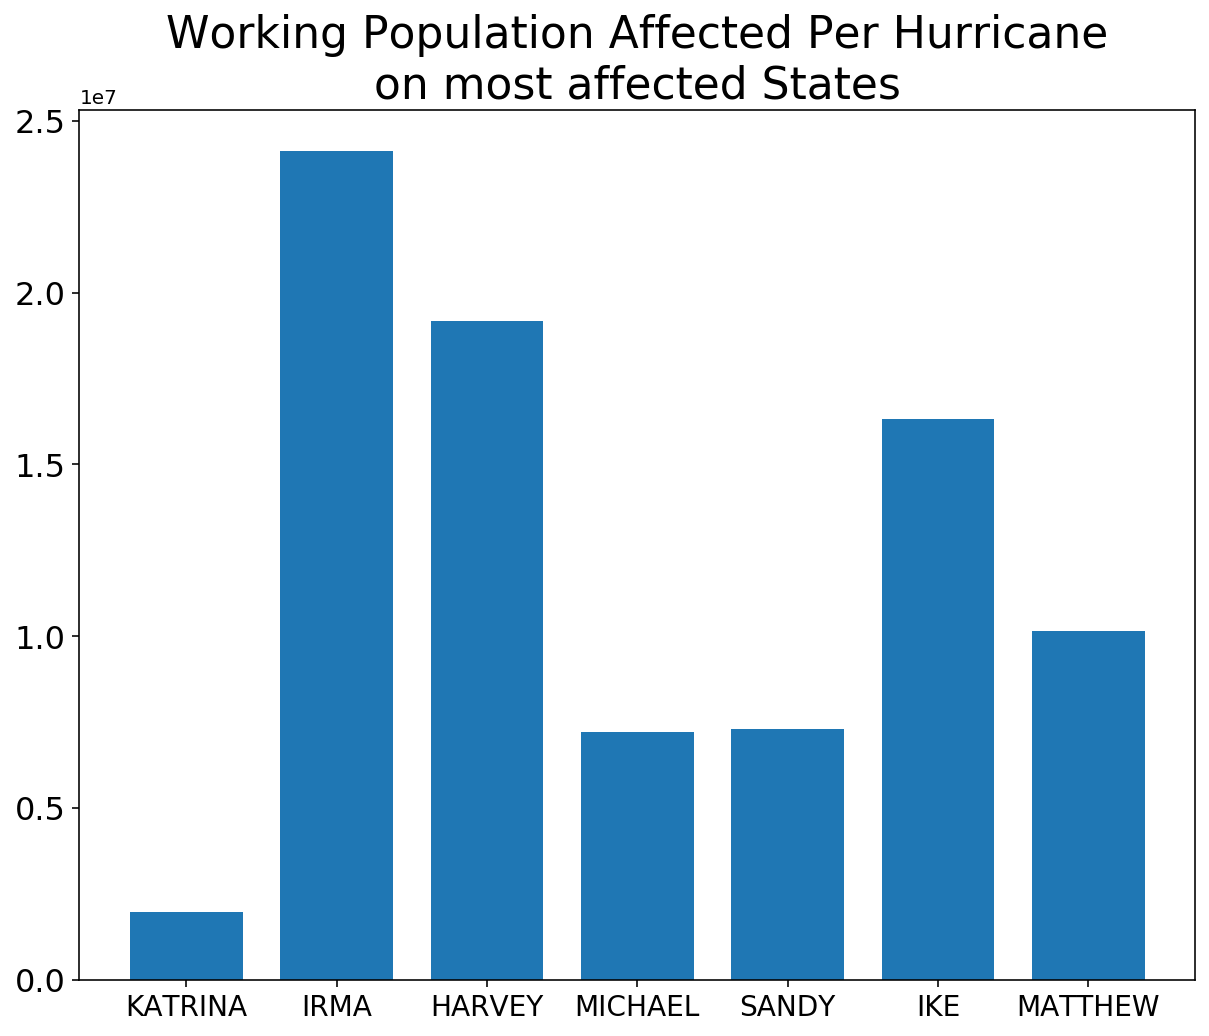

In [277]:
plt.figure(figsize=(10,8))
plt.bar(robbie.Title, robbie.employed,width=0.75);
plt.title('''Working Population Affected Per Hurricane
on most affected States''', fontsize=22);
plt.xticks(fontsize=14);
plt.yticks(fontsize=16);

In [144]:
mask = hurr_pop_inc[hurr_pop_inc['Disaster Type'] == 'DR']

In [181]:
hurr_pop_inc.shape

(245, 8)

In [146]:
mask.head()

,Disaster Number,Title,Disaster Type,Incident Begin Date,Incident Duration Days,state,employed,avg_wage_per_hour
0,627.0,ALLEN,DR,1980-08-11,0,TX,1236581.0,47.96
1,689.0,ALICIA,DR,1983-08-18,2,TX,4994880.0,47.96
2,724.0,DIANA,DR,1984-09-11,0,NC,272006.0,49.32
3,741.0,ELENA,DR,1985-08-29,6,MS,1064955.0,40.95
4,742.0,ELENA,DR,1985-08-29,4,AL,294460.0,45.66


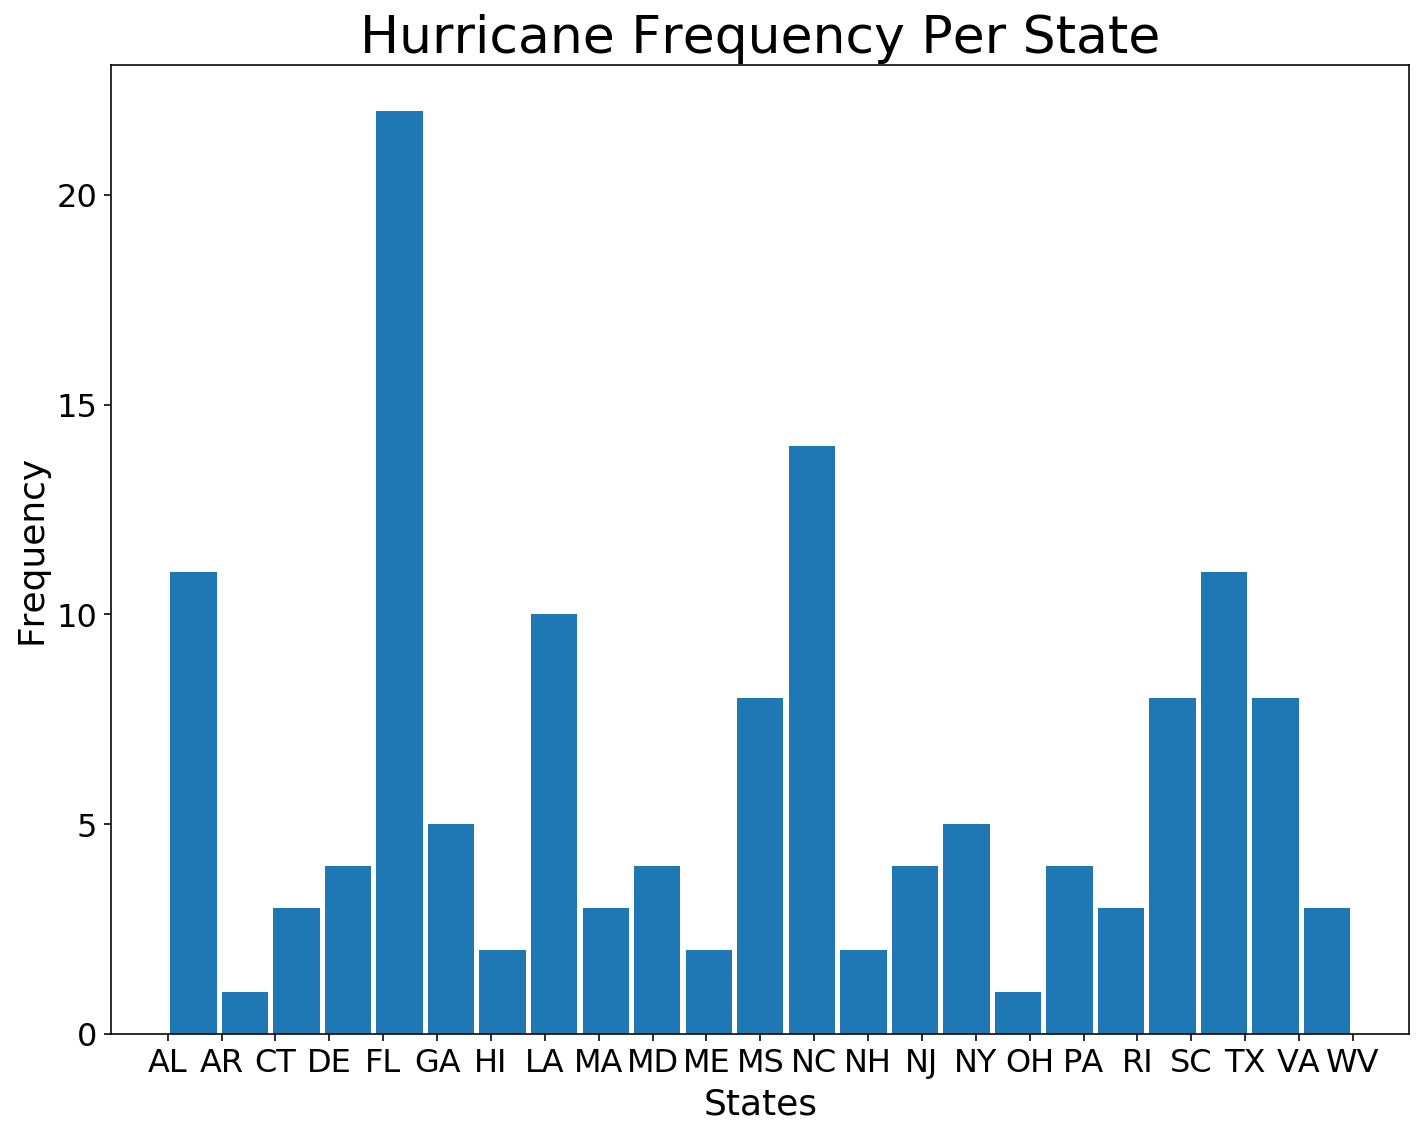

In [351]:
plt.figure(figsize=(10,8))
plt.hist(mask.state.sort_values(),bins=23,rwidth=0.9, align='mid');
plt.title('Hurricane Frequency Per State', fontsize=26);
plt.xlabel('States',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.tight_layout()

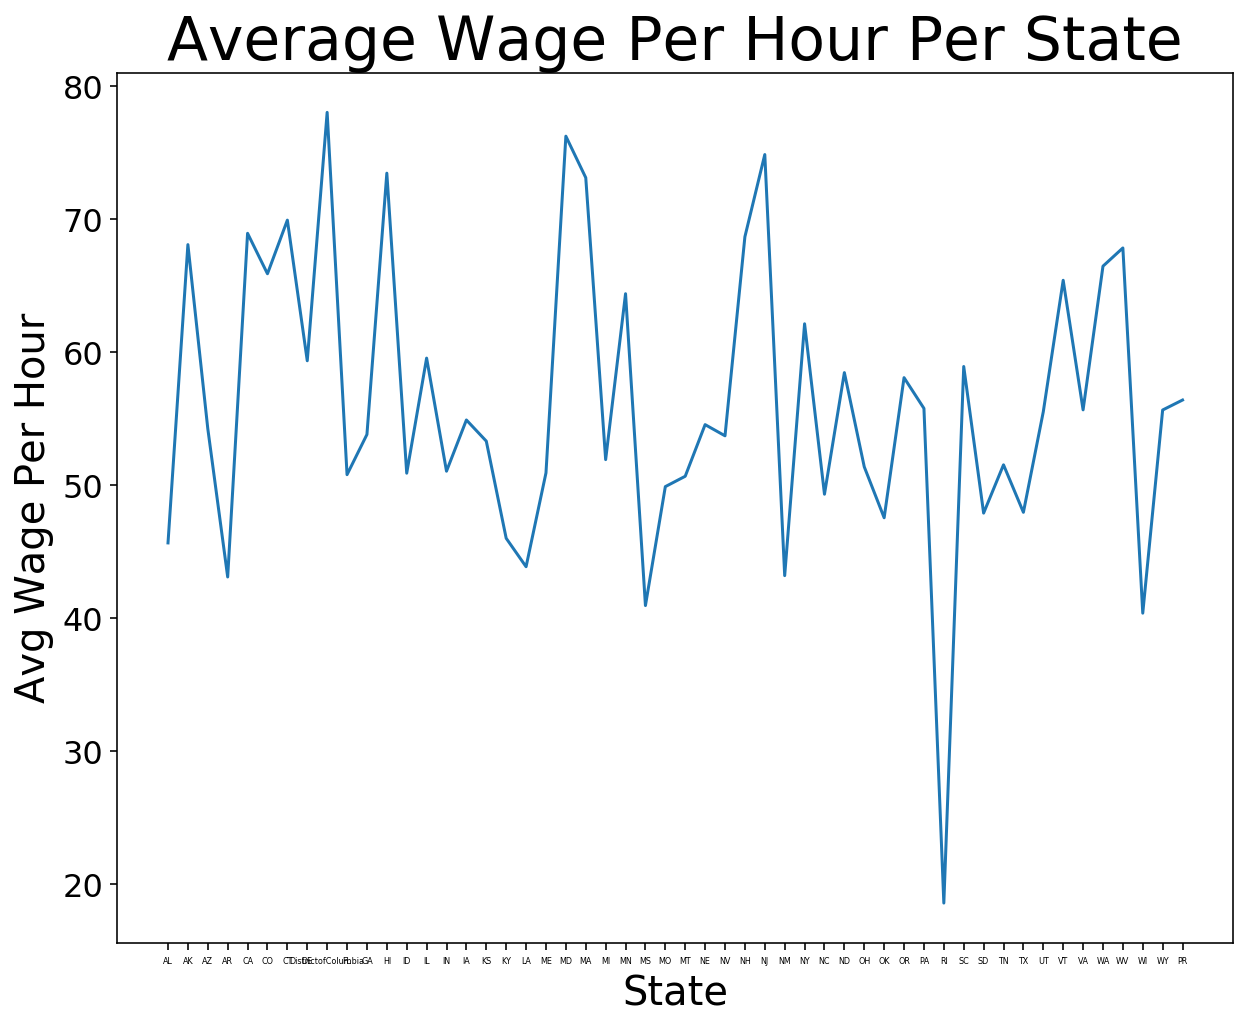

In [360]:
plt.figure(figsize=(10,8));
plt.plot(income.state, income.avg_wage_per_hour,);
plt.title('Average Wage Per Hour Per State', fontsize=30);
plt.xticks(ticks=None, labels=None, fontsize=4);
plt.xlabel('State', fontsize=20)
plt.ylabel('Avg Wage Per Hour', fontsize=20)
plt.yticks(fontsize=16);
# plt.tight_layout()

In [242]:
mask['Incident Duration Days'].nunique()

39

In [238]:
mask['Incident Duration Days'] = mask['Incident Duration Days'].astype(int)

/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [240]:
mask.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 244
Data columns (total 8 columns):
Disaster Number           138 non-null float64
Title                     138 non-null object
Disaster Type             138 non-null object
Incident Begin Date       138 non-null datetime64[ns]
Incident Duration Days    138 non-null int64
state                     138 non-null object
employed                  138 non-null float64
avg_wage_per_hour         138 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 9.7+ KB


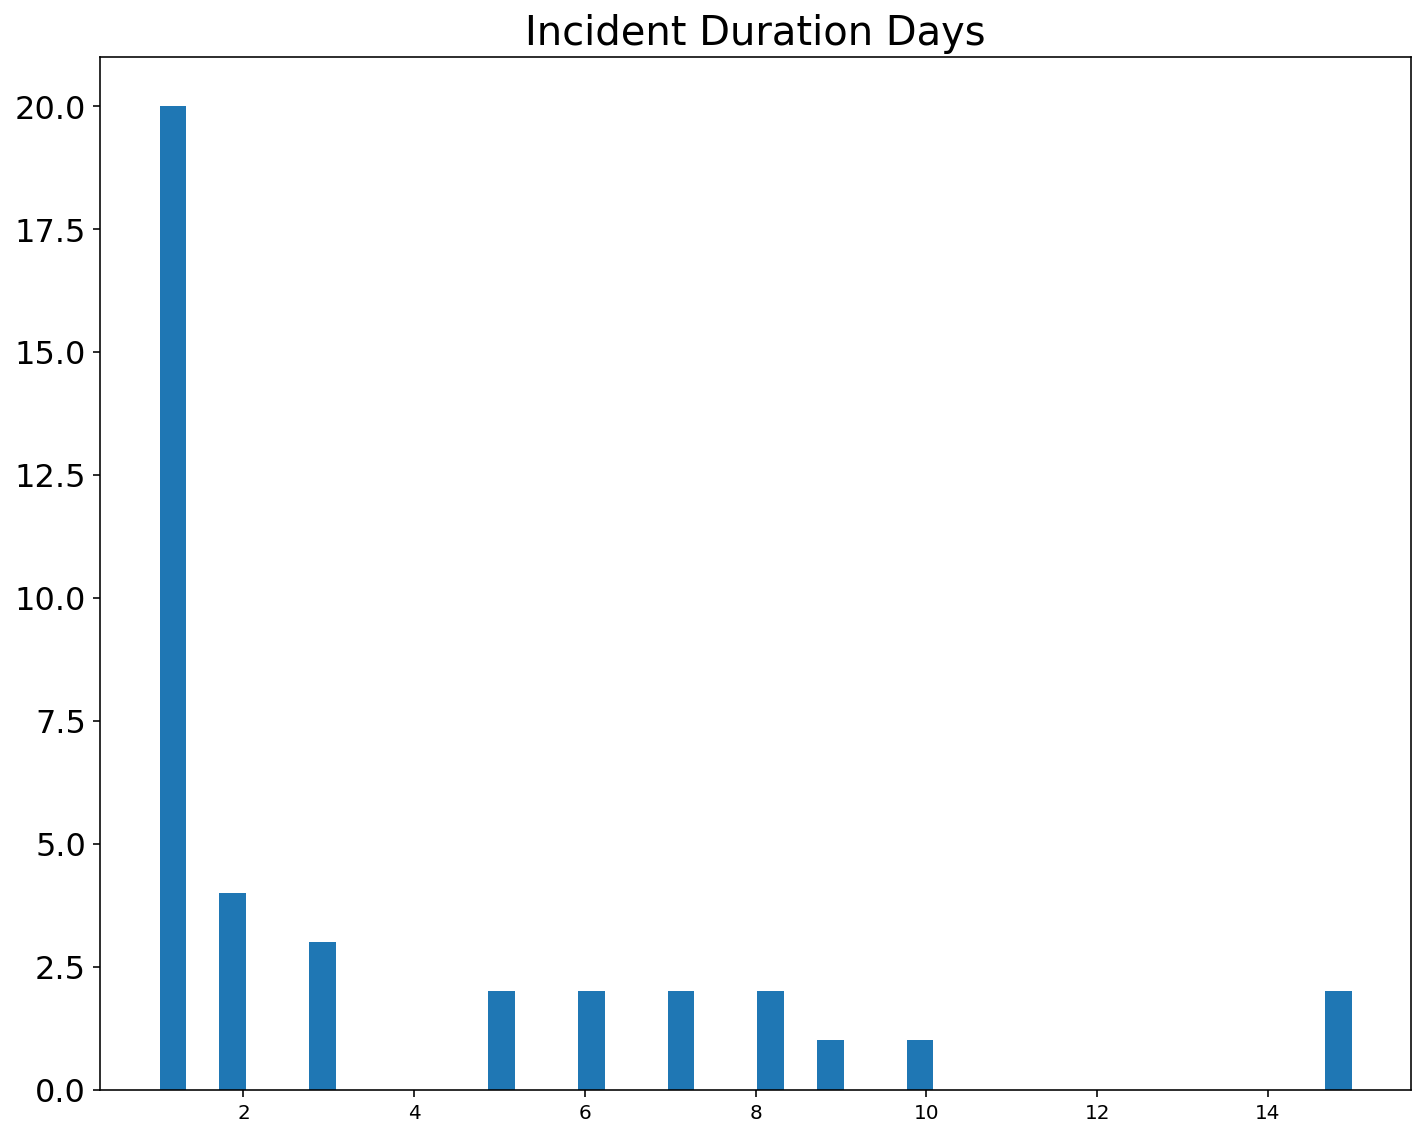

In [301]:
plt.figure(figsize=(10,8))
plt.hist(mask['Incident Duration Days'].value_counts().sort_index(),bins=40,rwidth=0.9, align='mid');
plt.title('Incident Duration Days', fontsize=20);
plt.xticks(fontsize=10);
plt.yticks(fontsize=16);
plt.tight_layout()

In [305]:
values = list(mask['Incident Duration Days'].value_counts().sort_index())
indeces = list(mask['Incident Duration Days'].value_counts().sort_index().index)

In [326]:
for i in range(len(values)):
    a[i] = pd.DataFrame([indeces[i],values[i]])

In [329]:
a = a.T
a = a.rename(columns={0:'duration_days', 1:'frequency'})

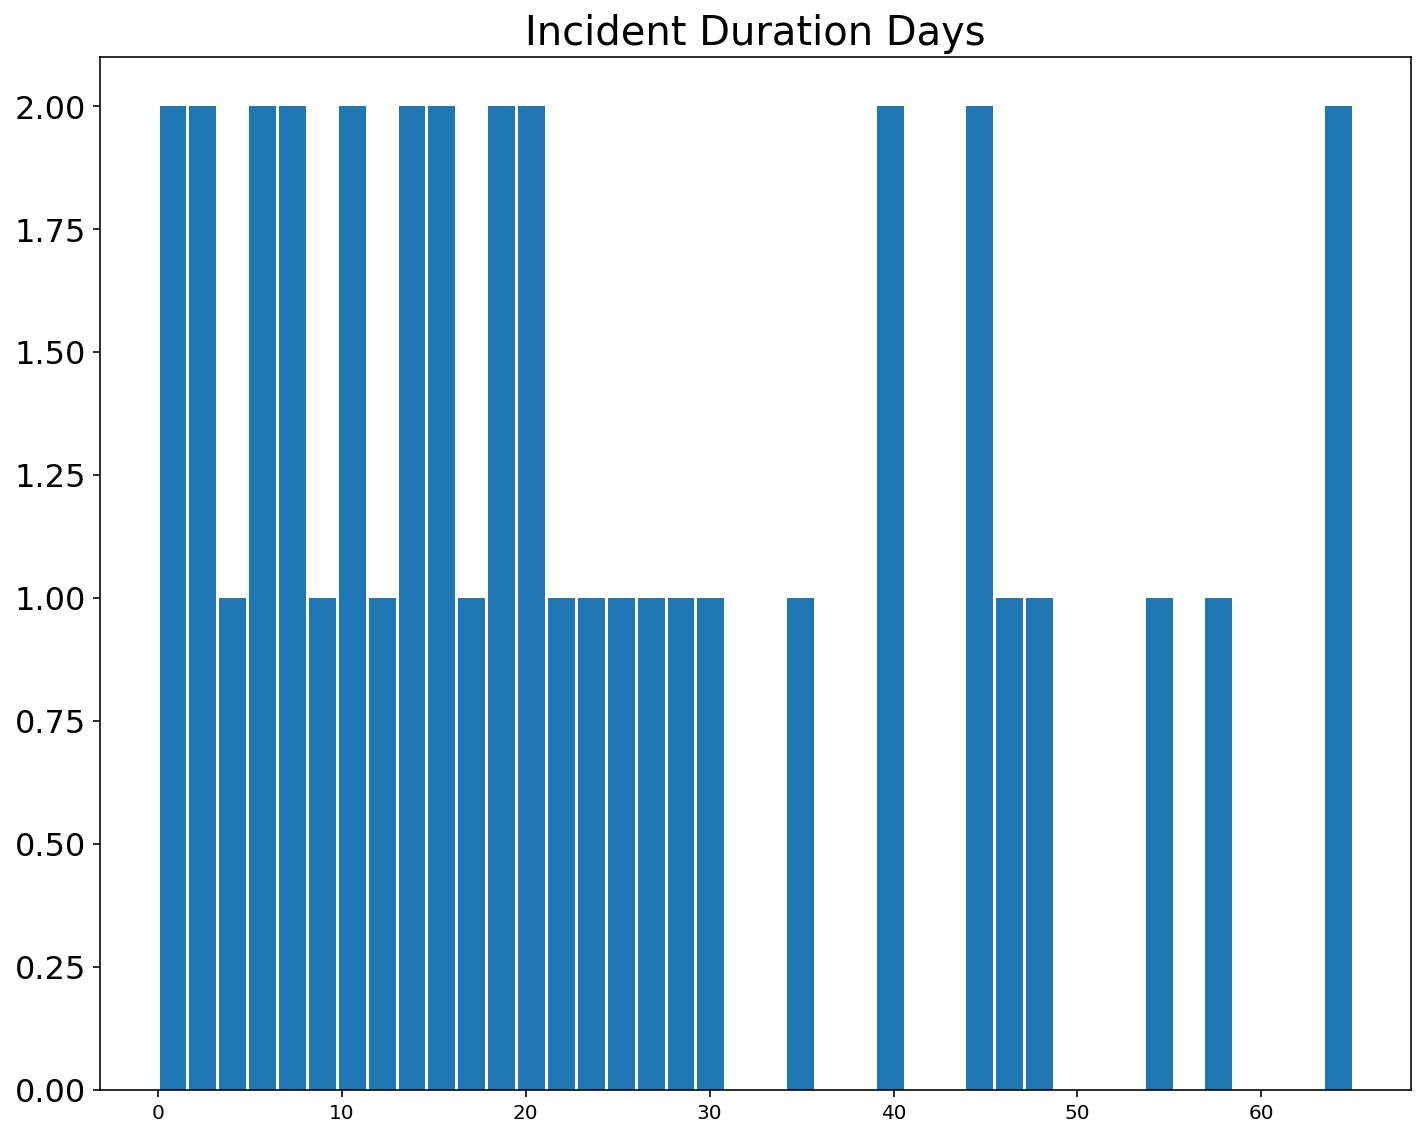

In [339]:
plt.figure(figsize=(10,8))
plt.hist(a.duration_days,bins=40,rwidth=0.9, align='mid');
plt.title('Incident Duration Days', fontsize=20);
plt.xticks(fontsize=10);
plt.yticks(fontsize=16);
plt.tight_layout()

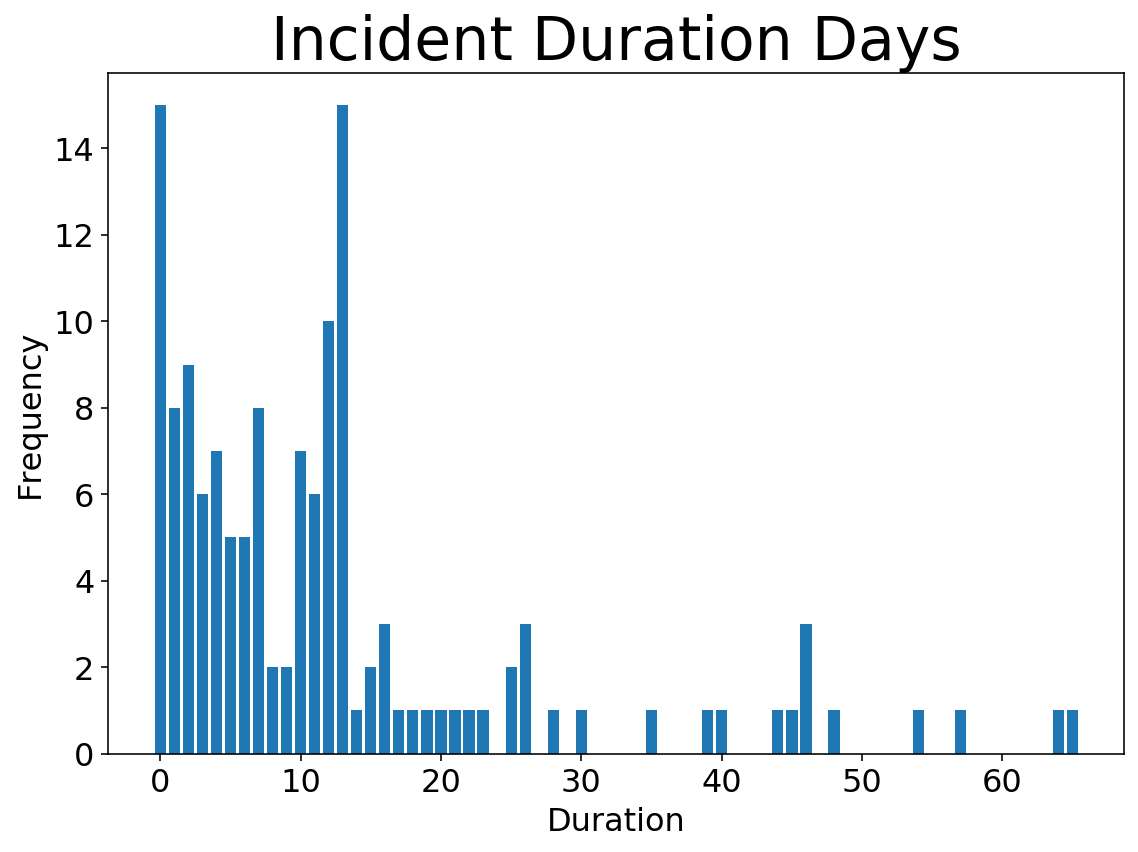

In [356]:
plt.figure(figsize=(8,6))
plt.bar(a['duration_days'], a['frequency'], width=0.8);
plt.title('Incident Duration Days', fontsize=30);
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('Duration',fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.tight_layout()

In [363]:
hurr_pop_inc

,Disaster Number,Title,Disaster Type,Incident Begin Date,Incident Duration Days,state,employed,avg_wage_per_hour
0,627.0,ALLEN,DR,1980-08-11,0,TX,1236581.0,47.96
1,689.0,ALICIA,DR,1983-08-18,2,TX,4994880.0,47.96
2,724.0,DIANA,DR,1984-09-11,0,NC,272006.0,49.32
3,741.0,ELENA,DR,1985-08-29,6,MS,1064955.0,40.95
4,742.0,ELENA,DR,1985-08-29,4,AL,294460.0,45.66
...,...,...,...,...,...,...,...,...
240,4395.0,LANE,DR,2018-08-22,7,HI,202357.0,73.45
241,4399.0,MICHAEL,DR,2018-10-07,12,FL,7202641.0,50.79
242,4400.0,MICHAEL,DR,2018-10-09,14,GA,12251659.0,53.81
243,4401.0,FLORENCE,DR,2018-09-08,13,VA,3428417.0,55.66


In [111]:
robbie.to_csv('../../datasets/seven_hurricanes.csv')